## NASA Web Server Log Analysis with Apache Spark

### STEP 1 : Introduction and Imports

* We are doing analysis on NASA access log dataset for the month of July and August.


* Folder Structure
    - log-anaysis-using-pyspark
        - dataset
            - log_aug.gz
            - log_jul.gz
        - Notebook.ipynb


* log_jul.gz - contains logs for month of July
* log_aug.gz - contains logs for month of August

#### Library Imports

In [1]:
# import libraries

# SparkSession
from pyspark.sql import SparkSession

# Regular expressions
import re

# Pandas
import pandas as pd

# creating sparkSession
spark = SparkSession.builder \
                    .appName("Log Analysis") \
                    .config("spark.some.config.option", "some-value") \
                    .getOrCreate()
spark

### STEP 2 : Exploratory Data Analysis

#### Loading the log file

In [2]:
# read data as dataframe
data_df = spark.read.text("dataset/*.gz")
print('Data types is : ', type(data_df))
print('Data type and column name : ', data_df)

Data types is :  <class 'pyspark.sql.dataframe.DataFrame'>
Data type and column name :  DataFrame[value: string]


In [3]:
# count number of records
print('Total rows and columns : ')
print((data_df.count(), len(data_df.columns)))

Total rows and columns : 
(3461613, 1)


In [4]:
# renaming default column name
data_df = data_df.withColumnRenamed("value", "log") 

# view schema of dataset
data_df.printSchema()

root
 |-- log: string (nullable = true)



In [5]:
# view dataset
data_df.show(5, truncate=False)

# details about dataset : host_name, timestamp, request, response_code, data_size

+-----------------------------------------------------------------------------------------------------------------------+
|log                                                                                                                    |
+-----------------------------------------------------------------------------------------------------------------------+
|199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245                                 |
|unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985                      |
|199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085   |
|burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0               |
|199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179|
+-----------------------

#### Parsing the log file

In [6]:
# get sample log for operations
sample_log_data = []
for item in data_df.take(10):
    sample_log_data.append(item["log"])
print('Sample log data is : \n', sample_log_data)

Sample log data is : 
 ['199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245', 'unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985', '199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085', 'burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0', '199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179', 'burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 304 0', 'burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/video/livevideo.gif HTTP/1.0" 200 0', '205.212.115.106 - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/countdown.html HTTP/1.0" 200 3985', 'd104.aa.net - - [01/Jul/1995:00:00:13 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985', '129.94.144.15

#### Fetching status code

In [7]:
# regex pattern for status code
# \s matches any whitespace character (equal to [\r\n\t\f\v ])
# capture group (\d{3}) \d{3} matches a digit (equal to [0-9]) {3} Quantifier — Matches exactly 3 times
status_code_regx = r'\s(\d{3})\s'
status = []
for item in sample_log_data:
    status.append(re.search(status_code_regx, item).group(1))
print(status)

['200', '200', '200', '304', '200', '304', '200', '200', '200', '200']


#### Fetching content size

In [8]:
# regex pattern for content size
# \s matches any whitespace character (equal to [\r\n\t\f\v ])
# \d+ matches a digit (equal to [0-9])
# + Quantifier — Matches between one and unlimited times, as many times as possible
# $ asserts position at the end of a line
content_size_regx = r'\s(\d+)$'
content_size = []
for item in sample_log_data:
    content_size.append(re.search(content_size_regx, item).group(1))
print(content_size)

['6245', '3985', '4085', '0', '4179', '0', '0', '3985', '3985', '7074']


#### Fetching host name

In [9]:
# regex pattern for host name
# 1st Capturing Group (^.[\S+\.]+\S+)
# ^ asserts position at start of a line . matches any character (except for line terminators)
# Match a single character present in the list below [\S+\.]+
# + Quantifier — Matches between one and unlimited times, as many times as possible
host_name_regx = r'(^\S+\.[\S+\.]+\S+)\s'
host_name = []
for item in sample_log_data:
    host_name.append(re.search(host_name_regx, item).group(1))
print(host_name)

['199.72.81.55', 'unicomp6.unicomp.net', '199.120.110.21', 'burger.letters.com', '199.120.110.21', 'burger.letters.com', 'burger.letters.com', '205.212.115.106', 'd104.aa.net', '129.94.144.152']


#### Fetching time stamp

In [10]:
# regex pattern for time stamp
# 1st Capturing Group (\d\d/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})
# \d matches a digit (equal to [0-9])
# \w{3} matches any word character (equal to [a-zA-Z0-9_])
# {3} Quantifier — Matches exactly 3 times
# \d{4} matches a digit (equal to [0-9])
# {4} Quantifier — Matches exactly 4 times
time_stamp_regx = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]'
time_stamp = []
for item in sample_log_data:
    time_stamp.append(re.search(time_stamp_regx, item).group(1))
print(time_stamp)

['01/Jul/1995:00:00:01 -0400', '01/Jul/1995:00:00:06 -0400', '01/Jul/1995:00:00:09 -0400', '01/Jul/1995:00:00:11 -0400', '01/Jul/1995:00:00:11 -0400', '01/Jul/1995:00:00:12 -0400', '01/Jul/1995:00:00:12 -0400', '01/Jul/1995:00:00:12 -0400', '01/Jul/1995:00:00:13 -0400', '01/Jul/1995:00:00:13 -0400']


#### Fetching methods, urls and protocol

In [11]:
# regex pattern for combined methods, urls and protocol
# 1st Capturing Group (\S+) \S+ matches any non-whitespace character (equal to [^\r\n\t\f\v ]) 
# + Quantifier — Matches between one and unlimited times, as many times as possible
# \s matches any whitespace character 
# \S* matches any non-whitespace character (equal to [^\r\n\t\f\v ])
methods_urls_protocol_regx = r'\"(\S+)\s(\S+)\s*(\S*)\"'
methods_urls_protocol = []
for item in sample_log_data:
    methods_urls_protocol.append(re.search(methods_urls_protocol_regx, item).groups())
print(methods_urls_protocol)

[('GET', '/history/apollo/', 'HTTP/1.0'), ('GET', '/shuttle/countdown/', 'HTTP/1.0'), ('GET', '/shuttle/missions/sts-73/mission-sts-73.html', 'HTTP/1.0'), ('GET', '/shuttle/countdown/liftoff.html', 'HTTP/1.0'), ('GET', '/shuttle/missions/sts-73/sts-73-patch-small.gif', 'HTTP/1.0'), ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0'), ('GET', '/shuttle/countdown/video/livevideo.gif', 'HTTP/1.0'), ('GET', '/shuttle/countdown/countdown.html', 'HTTP/1.0'), ('GET', '/shuttle/countdown/', 'HTTP/1.0'), ('GET', '/', 'HTTP/1.0')]


#### Combining it together

In [12]:
# import regex_extract for extraction of regex based data
from pyspark.sql.functions import regexp_extract

processed_data_df = data_df.select(regexp_extract('log', host_name_regx, 1).alias('host'),
                            regexp_extract('log', time_stamp_regx, 1).alias('timestamp'),
                            regexp_extract('log', methods_urls_protocol_regx, 1).alias('method'),
                            regexp_extract('log', methods_urls_protocol_regx, 2).alias('endpoint'),
                            regexp_extract('log', methods_urls_protocol_regx, 3).alias('protocol'),
                            regexp_extract('log', status_code_regx, 1).cast('integer').alias('status'),
                            regexp_extract('log', content_size_regx, 1).cast('integer').alias('content_size'))

In [13]:
# viewing new dataframe 
processed_data_df.show(10, truncate=True)

+--------------------+--------------------+------+--------------------+--------+------+------------+
|                host|           timestamp|method|            endpoint|protocol|status|content_size|
+--------------------+--------------------+------+--------------------+--------+------+------------+
|        199.72.81.55|01/Jul/1995:00:00...|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|
|unicomp6.unicomp.net|01/Jul/1995:00:00...|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   200|    

In [14]:
# schema of dataset
processed_data_df.printSchema()

root
 |-- host: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- method: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- content_size: integer (nullable = true)



In [15]:
# count of rows of new dataframe
print('Total rows and columns : ')
print((processed_data_df.count(), len(processed_data_df.columns)))

# now we have 7 columns

Total rows and columns : 
(3461613, 7)


### STEP : 3 Data Wrangling

In [16]:
# check null rows in original dataset
print('Count of null row : ', data_df.filter(data_df.log.isNull()).count())

Count of null row :  0


In [17]:
# check null value for each columns in processed dataset

# for host name
print('Null value count for host : ', processed_data_df.filter(processed_data_df['host'].isNull()).count())

Null value count for host :  0


In [18]:
# for timestamp
print('Null value count for timestamp : ', processed_data_df.filter(processed_data_df['timestamp'].isNull()).count())

Null value count for timestamp :  0


In [19]:
# for method
print('Null value count for method : ', processed_data_df.filter(processed_data_df['method'].isNull()).count())

Null value count for method :  0


In [20]:
# for endpoint
print('Null value count for endpoint : ', processed_data_df.filter(processed_data_df['endpoint'].isNull()).count())

Null value count for endpoint :  0


In [21]:
# for status
print('Null value count for status : ', processed_data_df.filter(processed_data_df['status'].isNull()).count())

Null value count for status :  1


In [22]:
# for content size
print('Null value count for content : ', processed_data_df.filter(processed_data_df['content_size'].isNull()).count())

Null value count for content :  33905


In [23]:
# for protocol
print('Null value count for protocol : ', processed_data_df.filter(processed_data_df['protocol'].isNull()).count())

Null value count for protocol :  0


In [24]:
# count the number of missing values in a dataframe
from pyspark.sql.functions import col,sum
processed_data_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in processed_data_df.columns)).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     1|       33905|
+----+---------+------+--------+--------+------+------------+



In [25]:
# view null value record
null_status_code_df = data_df.filter(~data_df['log'].rlike(status_code_regx))
null_status_code_df.show()

+--------+
|     log|
+--------+
|alyssa.p|
+--------+



NOTE : This record has only null value for status code.

In [26]:
# remove null status rows
processed_data_df = processed_data_df[processed_data_df['status'].isNotNull()] 
print('Records with null status removed : ', processed_data_df.count())

Records with null status removed :  3461612


In [27]:
# view dataset after wrangling status code
processed_data_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in processed_data_df.columns)).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|       33904|
+----+---------+------+--------+--------+------+------------+



In [28]:
# fill null content size with 0 value
processed_data_df = processed_data_df.na.fill({'content_size': 0})
print('Records after replacing it by 0 : ', processed_data_df.count())

Records after replacing it by 0 :  3461612


In [29]:
# view dataset after wrangling content_size
processed_data_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in processed_data_df.columns)).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+



NOTE : Now after data cleaning there is no missing values in our processed dataset.

#### Analysing timestamps

In [30]:
# view schema of proccessed df
processed_data_df.printSchema()

root
 |-- host: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- method: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- content_size: integer (nullable = false)



NOTE : Here timestamp column is of type string, so we have convert it in timestamp datatype for further analysis

In [31]:
# create map for month 
month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

# function to take date as string and returning in below format
def parse_to_timestamp(text):
    # taking only 20 character from the time value and slicing it accordingly
    time_format = "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}"
    return time_format.format(int(text[7:11]),
                              month_map[text[3:6]],
                              int(text[0:2]),
                              int(text[12:14]),
                              int(text[15:17]),
                              int(text[18:20])
                             )

In [32]:
# get sample log for operations
sample_timestamp = []
for item in processed_data_df.take(5):
    sample_timestamp.append(item["timestamp"])
print('Sample log data is : \n')
sample_timestamp

Sample log data is : 



['01/Jul/1995:00:00:01 -0400',
 '01/Jul/1995:00:00:06 -0400',
 '01/Jul/1995:00:00:09 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:11 -0400']

In [33]:
# check parse_to_timestamp function for sample df
print('Parsed data to timestamp')
[parse_to_timestamp(item) for item in sample_timestamp]

Parsed data to timestamp


['1995-07-01 00:00:01',
 '1995-07-01 00:00:06',
 '1995-07-01 00:00:09',
 '1995-07-01 00:00:11',
 '1995-07-01 00:00:11']

In [34]:
# import udf from sql.functions
from pyspark.sql.functions import udf
parse_to_timestamp_udf = udf(parse_to_timestamp)

processed_data_df = processed_data_df.select('*', parse_to_timestamp_udf(processed_data_df['timestamp']) \
                                     .cast('timestamp') \
                                     .alias('time')) \
                                     .drop('timestamp')
processed_data_df.show(5, truncate=True)

+--------------------+------+--------------------+--------+------+------------+-------------------+
|                host|method|            endpoint|protocol|status|content_size|               time|
+--------------------+------+--------------------+--------+------+------------+-------------------+
|        199.72.81.55|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|1995-07-01 00:00:01|
|unicomp6.unicomp.net|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|1995-07-01 00:00:06|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|1995-07-01 00:00:09|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|1995-07-01 00:00:11|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|1995-07-01 00:00:11|
+--------------------+------+--------------------+--------+------+------------+-------------------+
only showing top 5 rows



In [35]:
# view schema of proccessed df after parsing to timestamp
processed_data_df.printSchema()

root
 |-- host: string (nullable = true)
 |-- method: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- content_size: integer (nullable = false)
 |-- time: timestamp (nullable = true)



NOTE : Now the timestamp which was of type string now parsed to timestamp datatype.

#### Analysing HTTP status code 

In [36]:
# get count of distinct status code
status_code_df = (processed_data_df.select('status') \
                              .distinct() \
                              .count())
print('Count of distinct status code :', status_code_df)

Count of distinct status code : 8


NOTE : We have total of 8 distinct status code.

In [37]:
# view distinct status code
from pyspark.sql.functions import countDistinct
distinct_status = processed_data_df.groupBy('status') \
                                .agg(countDistinct('status') \
                                .alias('distinct_status'))
print('Distinct status code : ')
distinct_status.show()

Distinct status code : 
+------+---------------+
|status|distinct_status|
+------+---------------+
|   302|              1|
|   404|              1|
|   400|              1|
|   403|              1|
|   501|              1|
|   200|              1|
|   304|              1|
|   500|              1|
+------+---------------+



NOTE : These are distinct status code with count.

In [38]:
# count individual status code and sort it
from pyspark.sql.functions import desc
status_code_count = processed_data_df.groupBy("status") \
                                  .count() \
                                  .withColumnRenamed("count","distinct_status") \
                                  .sort(desc("count"))      
print('Status code count table :')
status_code_count.show()

Status code count table :
+------+---------------+
|status|distinct_status|
+------+---------------+
|   200|        3100524|
|   304|         266773|
|   302|          73070|
|   404|          20899|
|   403|            225|
|   500|             65|
|   501|             41|
|   400|             15|
+------+---------------+



In [39]:
# max count of status code
print('Max count of status code : ')
status_code_count.show(1)

Max count of status code : 
+------+---------------+
|status|distinct_status|
+------+---------------+
|   200|        3100524|
+------+---------------+
only showing top 1 row



In [40]:
# convert to pandas df
status_code_pd = status_code_count.toPandas()
print(status_code_pd.plot(kind='bar',x='status',y='distinct_status'))

AxesSubplot(0.125,0.11;0.775x0.77)


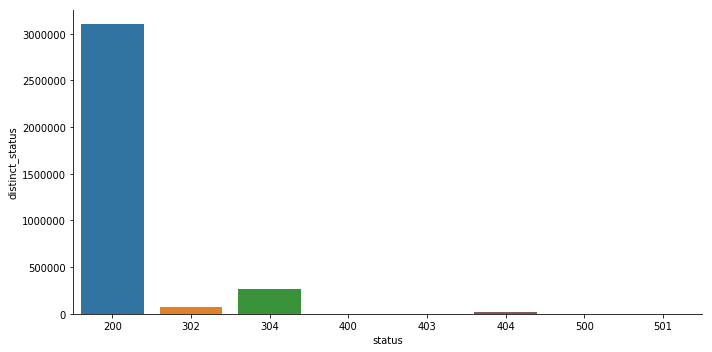

In [41]:
# import seaborn lib and use catplot for ploting graph
import seaborn as sns
status_bar_graph = sns.catplot(x='status', y='distinct_status', 
                               data=status_code_pd, 
                               kind='bar', height=5, aspect=2)

In [42]:
# count not found 404 error response status code
status_code_404_df = processed_data_df.filter(processed_data_df["status"] == 404)
print(('Total 404 responses: ', status_code_404_df.count()))

('Total 404 responses: ', 20899)


#### Analysis

From above we can infer following points about status code : -
1. Maximum status code count is 3100405

2. Status code for which max count is 200

#### Analyzing  Hosts Name

In [43]:
# get count of distinct hostname
host_name_df = (processed_data_df.select('host') \
                              .distinct() \
                              .count())
print('Count of distinct host name :', host_name_df)

Count of distinct host name : 137933


In [44]:
# count individual status code and sorting it
host_name_df = processed_data_df.groupBy("host") \
                                  .count() \
                                  .withColumnRenamed("count","distinct_host") \
                                  .sort(desc("count"))      
print('Host name count table :')
host_name_df.show(10, truncate=False)

Host name count table :
+--------------------+-------------+
|host                |distinct_host|
+--------------------+-------------+
|piweba3y.prodigy.com|21988        |
|piweba4y.prodigy.com|16437        |
|piweba1y.prodigy.com|12825        |
|edams.ksc.nasa.gov  |11964        |
|163.206.89.4        |9697         |
|news.ti.com         |8161         |
|www-d1.proxy.aol.com|8047         |
|alyssa.prodigy.com  |8037         |
|                    |7660         |
|siltb10.orl.mmc.com |7573         |
+--------------------+-------------+
only showing top 10 rows



In [45]:
# max count of host name
print('Max count of host name : ')
host_name_df.show(1, truncate=False)

Max count of host name : 
+--------------------+-------------+
|host                |distinct_host|
+--------------------+-------------+
|piweba3y.prodigy.com|21988        |
+--------------------+-------------+
only showing top 1 row



#### Analysis

From above we can infer following points about host name : -
1. Maximum host name count is 21291

2. Host name for which max count is piweba3y.prodigy.com

#### Analyzing  Endpoints

In [46]:
# get count of distinct endpoint
endpoints_df = (processed_data_df.select('endpoint') \
                              .distinct() \
                              .count())
print('Count of distinct endpoints :', endpoints_df)

Count of distinct endpoints : 31030


In [47]:
# count individual status code and sorting it
endpoints_df = processed_data_df.groupBy("endpoint") \
                                  .count() \
                                  .withColumnRenamed("count","distinct_endpoint") \
                                  .sort(desc("count"))      
print('Endpoint count table :')
endpoints_df.show(10, truncate=False)

Endpoint count table :
+---------------------------------------+-----------------+
|endpoint                               |distinct_endpoint|
+---------------------------------------+-----------------+
|/images/NASA-logosmall.gif             |208714           |
|/images/KSC-logosmall.gif              |164970           |
|/images/MOSAIC-logosmall.gif           |127908           |
|/images/USA-logosmall.gif              |127074           |
|/images/WORLD-logosmall.gif            |125925           |
|/images/ksclogo-medium.gif             |121572           |
|/ksc.html                              |83909            |
|/images/launch-logo.gif                |76006            |
|/history/apollo/images/apollo-logo1.gif|68896            |
|/shuttle/countdown/                    |64736            |
+---------------------------------------+-----------------+
only showing top 10 rows



In [48]:
# max count of endpoints
print('Max count of endpoint : ')
endpoints_df.show(1, truncate=False)

Max count of endpoint : 
+--------------------------+-----------------+
|endpoint                  |distinct_endpoint|
+--------------------------+-----------------+
|/images/NASA-logosmall.gif|208714           |
+--------------------------+-----------------+
only showing top 1 row



#### Analysis

From above we can infer following points about endpoints : -
1. Maximum endpoint is 208711

2. Endpoint name for which max count is /images/NASA-logosmall.gif

#### Analysing content size

In [49]:
# get statistics on content size 
content_size_stats_df = processed_data_df.describe(['content_size'])
content_size_stats_df.show()

+-------+------------------+
|summary|      content_size|
+-------+------------------+
|  count|           3461612|
|   mean|18928.844398216785|
| stddev| 73031.47260949228|
|    min|                 0|
|    max|           6823936|
+-------+------------------+



#### Analysis

From above we can infer following points about content size : -
1. Minimun content size is 0.

2. Maximum content size of data is 6823936 

3. Mean content size is 19264

#### Analyzing  Methods

In [50]:
# get count of distinct methods
methods_df = (processed_data_df.select('method') \
                              .distinct() \
                              .count())
print('Count of distinct method :', methods_df)

Count of distinct method : 5


In [51]:
# count individual status code and sorting it
methods_df = processed_data_df.groupBy("method") \
                                  .count() \
                                  .withColumnRenamed("count","distinct_method") \
                                  .sort(desc("count"))      
print('Method count table :')
methods_df.show(10, truncate=False)

Method count table :
+---------------+---------------+
|method         |distinct_method|
+---------------+---------------+
|GET            |3451720        |
|HEAD           |7915           |
|               |1753           |
|POST           |222            |
|�|t�9ð'À|u|2              |
+---------------+---------------+



In [52]:
# max count of method
print('Max count of method : ')
methods_df.show(1, truncate=False)

Max count of method : 
+------+---------------+
|method|distinct_method|
+------+---------------+
|GET   |3451720        |
+------+---------------+
only showing top 1 row



AxesSubplot(0.125,0.125;0.775x0.755)


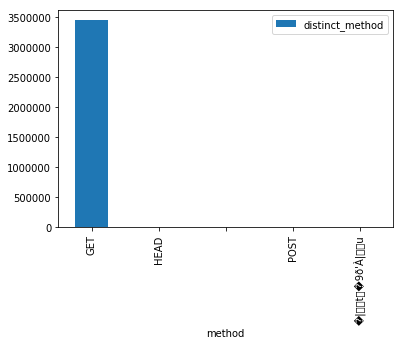

In [53]:
# convert to pandas df
method_pd = methods_df.toPandas()
print(method_pd.plot(kind='bar',x='method',y='distinct_method'))

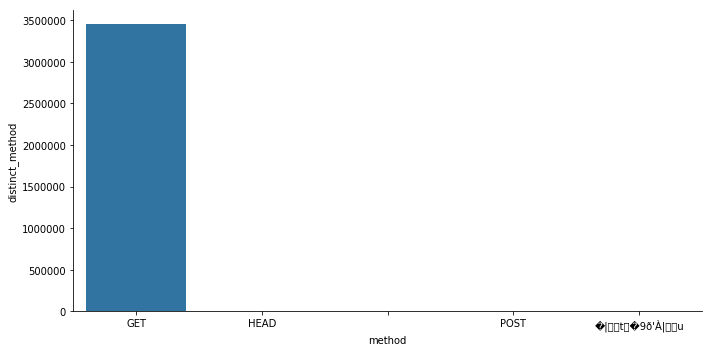

In [54]:
# use catplot for ploting graph
method_bar_graph = sns.catplot(x='method', y='distinct_method', 
                               data=method_pd, 
                               kind='bar', height=5, aspect=2)

#### Analyzing  Protocol

In [55]:
# get count of distinct protocol
protocol_df = (processed_data_df.select('protocol') \
                              .distinct() \
                              .count())
print('Count of distinct protocol :', protocol_df)

Count of distinct protocol : 6


In [56]:
# count individual protocol and sorting it
protocol_df = processed_data_df.groupBy("protocol") \
                                  .count() \
                                  .withColumnRenamed("count","distinct_protocol") \
                                  .sort(desc("count"))      
print('Protocol count table :')
protocol_df.show(10, truncate=False)

Protocol count table :
+-------------+-----------------+
|protocol     |distinct_protocol|
+-------------+-----------------+
|HTTP/1.0     |3454716          |
|             |6599             |
|HTTP/V1.0    |279              |
|HTTP/*       |13               |
|STS-69</a><p>|4                |
|a            |1                |
+-------------+-----------------+



In [57]:
# max count of protocol
print('Max count of protocol : ')
protocol_df.show(1, truncate=False)

Max count of protocol : 
+--------+-----------------+
|protocol|distinct_protocol|
+--------+-----------------+
|HTTP/1.0|3454716          |
+--------+-----------------+
only showing top 1 row



AxesSubplot(0.125,0.125;0.775x0.755)


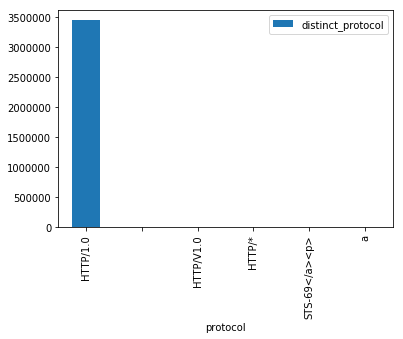

In [58]:
# convert to pandas df
protocol_pd = protocol_df.toPandas()
print(protocol_pd.plot(kind='bar',x='protocol',y='distinct_protocol'))

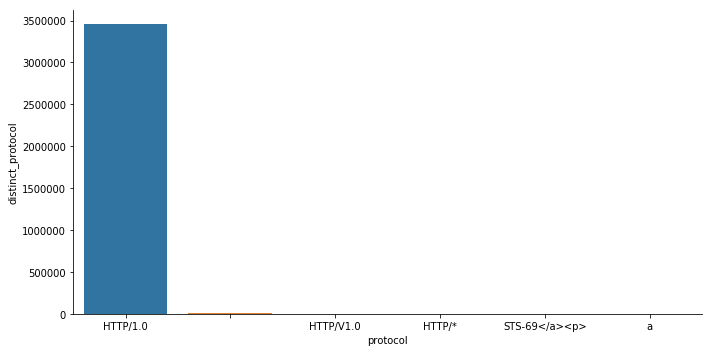

In [59]:
# use catplot for ploting graph
protocol_bar_graph = sns.catplot(x='protocol', y='distinct_protocol', 
                               data=protocol_pd, 
                               kind='bar', height=5, aspect=2)